## Histograms of errors in the predicted peak parameters and compares them against gaussian distributions and displays the resulting plots

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

Ranges of parameters in units and constants used in experiment.

In [2]:
sp_min, sp_max = -10., 10.
fr_min, fr_max = 0., 256.
dc_min, dc_max = 0.1, 10.
am_min, am_max = 0.1, 5.

series = 20
dwmin, dwmax = -10., 10.

Number of pixels and cells along the speed and frequency dimension.

In [3]:
sp_pixels, fr_pixels = 256, 256
sp_cells, fr_cells = 16, 16

Offsets of cells relative to the entire grid in range from 0 to the number of cells.

In [4]:
fr_offsets, sp_offsets = tf.meshgrid(tf.range(fr_cells, dtype = tf.float32),
                                     tf.range(sp_cells, dtype = tf.float32))

Takes a spectrum and returns objectness and peak shifts on the grid.

In [5]:
spectrum = tf.keras.Input([256, 256])
signal = tf.keras.layers.Reshape([256, 256, 1])(spectrum)
signal = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(128, 128, 32)
signal = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(64, 64, 64)
signal = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(32, 32, 128)
signal = tf.keras.layers.Conv2D(256, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(256, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(16, 16, 256)
signal = tf.keras.layers.Conv2D(512, 3, 1, 'same', activation = 'relu')(signal)
ob_logits = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
ob_logits = tf.keras.layers.Reshape([16, 16])(ob_logits)
sp_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
sp_shifts = tf.keras.layers.Reshape([16, 16])(sp_shifts)
fr_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
fr_shifts = tf.keras.layers.Reshape([16, 16])(fr_shifts)
dc_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
dc_shifts = tf.keras.layers.Reshape([16, 16])(dc_shifts)
am_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
am_shifts = tf.keras.layers.Reshape([16, 16])(am_shifts)
model = tf.keras.models.Model(spectrum, (ob_logits, sp_shifts, fr_shifts, dc_shifts, am_shifts))

Load the model weights.

In [6]:
model.load_weights('model/05extract.h5')

Auxiliary arrays for generating spectrum in tensorflow.

In [7]:
t = tf.complex(tf.range(2 * fr_pixels, dtype = tf.float32) / fr_pixels / 2., 0.)
a = tf.range(series, dtype = tf.float32)
b = 2. * math.pi * \
    tf.complex(0., tf.range(dwmin, dwmax, (dwmax - dwmin) / sp_pixels, dtype = tf.float32))[:, None] * t

Function to take peak parameters and returns the resulting spectrum.

In [8]:
@tf.function
def get(ob_labels, sp_values, fr_values, dc_values, am_values):
    f = a[:, None, None] * sp_values + fr_values + fr_pixels / 2.
    fid = tf.complex(ob_labels * am_values, 0.) * \
          tf.exp(2. * math.pi * t[:, None, None, None] * (tf.complex(-dc_values, f))) * \
          tf.cast(tf.logical_and(0.8 * fr_pixels / 2. <= f, f <= 2. * fr_pixels - 0.8 * fr_pixels / 2.), 
                  tf.complex64)
    fid = tf.reduce_sum(fid, [2, 3])
    fid = tf.concat([fid[: 1] / 2., fid[1:]], 0)
    p = tf.exp(-b[:, :, None] * tf.complex(a, 0.)) * fid
    return tf.math.real(tf.signal.fft(tf.reduce_sum(p, 2)))[:, fr_pixels // 2 : 2 * fr_pixels - fr_pixels // 2]

Function to draw random peak parameters and yield the resulting spectrum.

In [9]:
def generate():
    while True:
        #Random number of peaks from 1 to 9
        count = tf.random.uniform([], 1, 10, dtype = tf.int32)
        #Random objectness labels as 1. or 0. if a cell contains a peak or not
        ob_labels = tf.concat([tf.ones([count]), tf.zeros([sp_cells * fr_cells - count])], -1)
        ob_labels = tf.random.shuffle(ob_labels)
        ob_labels = tf.reshape(ob_labels, [sp_cells, fr_cells])
        #Random peak parameters relative to each cell in range from 0 to 1
        sp_shifts = tf.random.uniform([sp_cells, fr_cells])
        fr_shifts = tf.random.uniform([sp_cells, fr_cells])
        dc_shifts = tf.random.uniform([sp_cells, fr_cells])
        am_shifts = tf.random.uniform([sp_cells, fr_cells])
        #Peak parameters relative to the entire grid in range from 0 to 1
        sp_units = (sp_offsets + sp_shifts) / sp_cells
        fr_units = (fr_offsets + fr_shifts) / fr_cells
        dc_units = dc_shifts
        am_units = am_shifts
        #Peak parameters in units used in experiment
        sp_values = sp_units * (sp_max - sp_min) + sp_min
        fr_values = fr_units * (fr_max - fr_min) + fr_min
        dc_values = dc_units * (dc_max - dc_min) + dc_min
        am_values = am_units * (am_max - am_min) + am_min
        spectrum = get(ob_labels, sp_values, fr_values, dc_values, am_values)
        yield spectrum, (ob_labels, sp_shifts, fr_shifts, dc_shifts, am_shifts)

Function of normalize spectra to zero mean and unit variance.

In [10]:
@tf.function
def normalize(spectrum, target):
    spectrum = (spectrum - 180.45589) / 217.40448
    return spectrum, target

Batched dataset of normalized spectra from function of generate.

In [11]:
dataset = tf.data.Dataset.from_generator(generate,
                                         output_signature = (tf.TensorSpec([sp_pixels, fr_pixels]),
                                                             (tf.TensorSpec([sp_cells, fr_cells]),
                                                              tf.TensorSpec([sp_cells, fr_cells]),
                                                              tf.TensorSpec([sp_cells, fr_cells]),
                                                              tf.TensorSpec([sp_cells, fr_cells]),
                                                              tf.TensorSpec([sp_cells, fr_cells]))))
dataset = dataset.map(normalize).batch(16384)

Generated spectra and true objectness labels and peak shifts.

In [12]:
spectrum, (ob_labels0, sp_shifts0, fr_shifts0, dc_shifts0, am_shifts0) = next(iter(dataset))

Predicted objectness logits and peak shifts.

In [13]:
ob_logits1, sp_shifts1, fr_shifts1, dc_shifts1, am_shifts1 = model.predict(spectrum)

Offsets of cells relative to the entire grid in range from 0 to the number of cells.

In [14]:
sp_offsets = sp_offsets.numpy()
fr_offsets = fr_offsets.numpy()

True peak shifts.

In [15]:
sp_shifts0 = sp_shifts0.numpy()
fr_shifts0 = fr_shifts0.numpy()
dc_shifts0 = dc_shifts0.numpy()
am_shifts0 = am_shifts0.numpy()

True peak units and predicted peak units.

In [16]:
sp_units0 = (sp_offsets + sp_shifts0) / sp_cells
fr_units0 = (fr_offsets + fr_shifts0) / fr_cells
dc_units0 = dc_shifts0
am_units0 = am_shifts0

sp_units1 = (sp_offsets + sp_shifts1) / sp_cells
fr_units1 = (fr_offsets + fr_shifts1) / fr_cells
dc_units1 = dc_shifts1
am_units1 = am_shifts1

True objectness labels and predicted objectness labels.

In [17]:
ob_labels0 = ob_labels0.numpy()
ob_labels0 = ob_labels0 > 0.5

ob_labels1 = ob_logits1 > 0.

Objectness labels for correctly predicted peaks.

In [18]:
ob_labels = np.logical_and(ob_labels1, ob_labels0)

Normal probability distribution.

In [19]:
def gauss(x, mean, std):
    return np.exp(-((x - mean) / std) ** 2 / 2) / std / np.sqrt(2 * np.pi)

Abscissa for plotting normal distributions.

In [20]:
coarse = np.linspace(-0.5, 0.5, 256)
fine = np.linspace(-0.05, 0.05, 256)

True shifts for correctly predicted peaks and predicted shifts for correctly predicted peaks.

In [21]:
sp_shifts0 = sp_shifts0[ob_labels]
fr_shifts0 = fr_shifts0[ob_labels]
dc_shifts0 = dc_shifts0[ob_labels]
am_shifts0 = am_shifts0[ob_labels]

sp_shifts1 = sp_shifts1[ob_labels]
fr_shifts1 = fr_shifts1[ob_labels]
dc_shifts1 = dc_shifts1[ob_labels]
am_shifts1 = am_shifts1[ob_labels]

### Histogram of errors in shifts for correctly predicted peaks

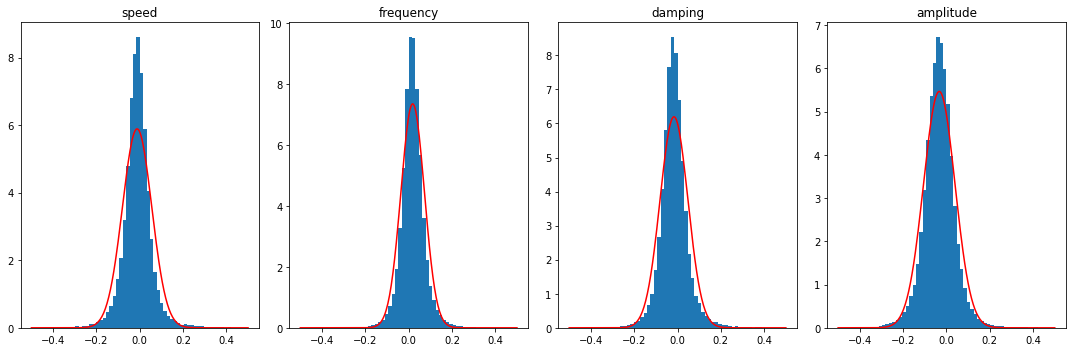

In [22]:
plt.figure(tight_layout = True, figsize=(15,5))
plt.subplot(1, 4, 1, title = 'speed')
plt.hist(sp_shifts1 - sp_shifts0, density = True, bins = 64, range = (-0.5, 0.5))
plt.plot(coarse, gauss(coarse, -0.012211184, 0.06775286), color = 'red')
plt.subplot(1, 4, 2, title = 'frequency')
plt.hist(fr_shifts1 - fr_shifts0, density = True, bins = 64, range = (-0.5, 0.5))
plt.plot(coarse, gauss(coarse, 0.018592654, 0.054280385), color = 'red')
plt.subplot(1, 4, 3, title = 'damping')
plt.hist(dc_shifts1 - dc_shifts0, density = True, bins = 64, range = (-0.5, 0.5))
plt.plot(coarse, gauss(coarse, -0.016420918, 0.06437582), color = 'red')
plt.subplot(1, 4, 4, title = 'amplitude')
plt.hist(am_shifts1 - am_shifts0, density = True, bins = 64, range = (-0.5, 0.5))
plt.plot(coarse, gauss(coarse, -0.033154927, 0.072993636), color = 'red')

plt.show()

True units for correctly predicted peaks and predicted units for correctly predicted peaks.

In [23]:
sp_units0 = sp_units0[ob_labels]
fr_units0 = fr_units0[ob_labels]
dc_units0 = dc_units0[ob_labels]
am_units0 = am_units0[ob_labels]

sp_units1 = sp_units1[ob_labels]
fr_units1 = fr_units1[ob_labels]
dc_units1 = dc_units1[ob_labels]
am_units1 = am_units1[ob_labels]

### Histogram of errors in units for correctly predicted peaks

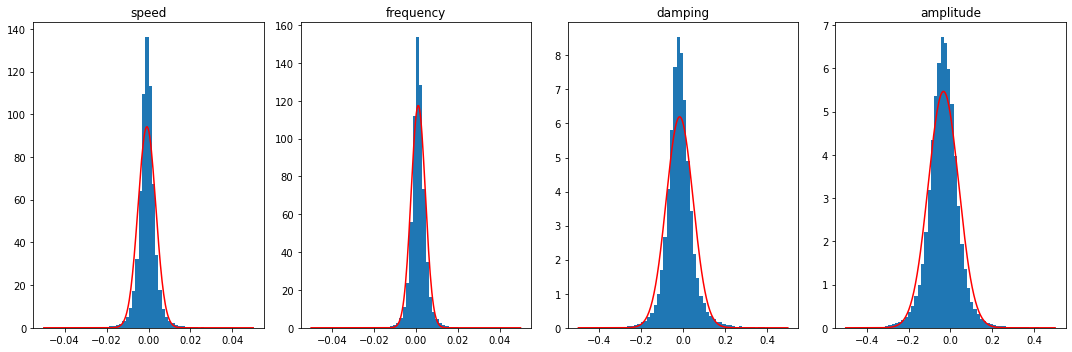

In [24]:
plt.figure(tight_layout = True, figsize=(15,5))
plt.subplot(1, 4, 1, title = 'speed')
plt.hist(sp_units1 - sp_units0, density = True, bins = 64, range = (-0.05, 0.05))
plt.plot(fine, gauss(fine, -0.00076319894, 0.004234554), color = 'red')
plt.subplot(1, 4, 2, title = 'frequency')
plt.hist(fr_units1 - fr_units0, density = True, bins = 64, range = (-0.05, 0.05))
plt.plot(fine, gauss(fine, 0.0011620407, 0.003392524), color = 'red')
plt.subplot(1, 4, 3, title = 'damping')
plt.hist(dc_units1 - dc_units0, density = True, bins = 64, range = (-0.5, 0.5))
plt.plot(coarse, gauss(coarse, -0.016420918, 0.06437582), color = 'red')
plt.subplot(1, 4, 4, title = 'amplitude')
plt.hist(am_units1 - am_units0, density = True, bins = 64, range = (-0.5, 0.5))
plt.plot(coarse, gauss(coarse, -0.033154927, 0.072993636), color = 'red')

plt.show()